In [7]:
import subprocess
from IPython.display import Image
import os.path
def plotbtree(btree, fname, redo=False, augmented=False):
    if os.path.exists(fname+".png") and not redo:
        return Image(fname+".png")
    start="""
    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    """
    end = "}"
    assert btree.isRoot(), "Must start at root"
    lines=""
    labeldict={}
    for t in btree.preorder():
        if not t[0].uuid in labeldict:
            labeldict[t[0].uuid]=t[0]
        if not t[1].uuid in labeldict:
            labeldict[t[1].uuid]=t[1]
        lines = lines + "\"{}\" -> \"{}\"[side={}];\n".format(t[0].uuid,t[1].uuid,t[2])
    if augmented:
        end="\n".join(["\"{}\"[label=<{}<BR/><FONT POINT-SIZE=\"10\">{},{}</FONT>>]".format(k,v.data,v.size, v.count) for (k, v) in labeldict.items()])+end
    else:
        end="\n".join(["\"{}\"[label=<{}<BR/><FONT POINT-SIZE=\"10\">count={}</FONT>>]".format(k,v.data,v.count) for (k, v) in labeldict.items()])+end
       
    start = start + lines +end
    with open(fname+".dot","w") as fd:
        fd.write(start)
    subprocess.call(['./treeplot.sh', fname])
    return Image(fname+".png")

In [1]:
import uuid
class BinaryTree:
    def __init__(self, data, parent=None):
        self.data = data
        self.parent = parent
        self.uuid= uuid.uuid4()
        self.left = None
        self.right = None    
            
    def addLeftChild(self, data): 
        n = self.__class__(data, self)
        self.left = n
        return n
        
    def addRightChild(self, data):
        n = self.__class__(data, self)
        self.right = n
        return n
        
    def hasLeftChild(self):
        return self.left is not None

    def hasRightChild(self):
        return self.right is not None

    def hasAnyChild(self):
        return self.hasRightChild() or self.hasLeftChild()

    def hasBothChildren(self):
        return self.hasRightChild() and self.hasLeftChild()
    
    def hasNoChildren(self):
        return not self.hasRightChild() and not self.hasLeftChild()
    
    def isLeftChild(self):
        return self.parent and self.parent.left == self

    def isRightChild(self):
        return self.parent and self.parent.right == self

    def isRoot(self):
        return not self.parent

    def isLeaf(self):
        return not (self.right or self.left)
    
            
    def preorder(self):
        if self.isLeftChild():
            yield (self.parent, self, "left")
        elif self.isRightChild():
            yield (self.parent, self, "right")
        if self.hasLeftChild():
            for v in self.left.preorder():
                yield v
        if self.hasRightChild():
            for v in self.right.preorder():
                yield v


In [2]:
class BinarySearchTree(BinaryTree):
        
    def __init__(self, data, parent=None):
        super().__init__(data, parent)
        self.count = 1

    def _insert_hook(self):
        pass
            
    def insert(self, data):
        if data < self.data:
            if self.hasLeftChild():
                self.left.insert(data)
            else:
                self.addLeftChild(data)
                self._insert_hook()
        elif data > self.data:
            if self.hasRightChild():
                self.right.insert(data)
            else:
                self.addRightChild(data)
                self._insert_hook()
        else: #duplicate value
            self.count += 1
            self._insert_hook()
            
    def search(self, data):
        if self.data == data:
            return self
        elif data < self.data and self.left:
            return self.left.search(data)
        elif data > self.data and self.right:
            return self.right.search(data)
        else:
            return None
        
    def delete(self, data):        
        if self.isRoot() and self.hasNoChildren() and self.data==data:#deleting the whole tree
            self.root=None#todo call a destructor that signals GC it can reap
            #self._update_sizes(up=False) #really tree is gone
            self._remove_hook()
        elif self.hasAnyChild():
            noder = self.search(data)
            if noder:
                self._remove(noder)
            else:
                raise ValueError("No such data {} in tree".format(data))
        else:
            raise ValueError("No such data {} in tree".format(data))

    def _remove_hook(self, up=False, by=1):
        pass
    
    def _remove(self, node):
        if node.isLeaf():
            if node.isLeftChild():
                node.parent.left = None
            else:
                node.parent.right = None
            #node._update_sizes(up=False, by=node.count)
            node._remove_hook(by=node.count)
            del node
        elif node.hasBothChildren():
            s = node.successor()
            #successor is guaranteed to have right child only
            s.spliceOut()
            #s._update_sizes(up=False, by=s.count)
            s._remove_hook(by=s.count)
            #handled more generally above
            #s.right.parent = s.parent
            #s.parent.left = s.right
            node.data = s.data
            #diff = s.count - node.count            
            #node._update_sizes(by=diff)
            node._remove_hook(up=True, by = s.count - node.count)
            node.count = s.count
            del s #the node became the successor
        else: # one child case
            if node.hasLeftChild():
                if node.isLeftChild():
                    node.left.parent = node.parent
                    node.parent.left = node.left
                elif node.isRightChild():
                    node.left.parent = node.parent
                    node.parent.right = node.left
                else: #root
                    self.root = node.left
                #node._update_sizes(up=False, by=node.count)
                node._remove_hook(by=node.count)
                del node
            else:
                if node.isLeftChild():
                    node.right.parent = node.parent
                    node.parent.left = node.right
                elif node.isRightChild():
                    node.right.parent = node.parent
                    node.parent.right = node.right
                else: #root
                    self.root = node.right
                #node._update_sizes(up=False, by=node.count)
                node._remove_hook(by=node.count)
                del node
                    
    def findMin(self):
        minnode = self
        while minnode.hasLeftChild():
            minnode = minnode.left
        return minnode
    
    def findMax(self):
        maxnode = self
        while maxnode.hasRightChild():
            maxnode = maxnode.right
        return maxnode
    
    def successor(self):
        s = None
        if self.hasRightChild():
            s = self.right.findMin()
        else:
            if self.parent:
                if self.isLeftChild():
                    s = self.parent
                else:
                    self.parent.right=None
                    s = self.parent.successor()
                    self.parent.right=self
        return s
    
    def predecessor(self):
        p=None
        if self.hasLeftChild():
            p = self.left.findMax()
        else:
            if self.parent:
                if self.isRightChild():
                    p = self.parent
                else:
                    self.parent.left = None
                    p = self.parent.predecessor()
                    self.parent.left = self
        return p
            
    def spliceOut(self):
        if self.isLeaf():
            if self.isLeftChild():
                self.parent.left = None
            else:
                self.parent.right = None
        elif self.hasAnyChild():
            if self.hasLeftChild():
                if self.isLeftChild():
                    self.parent.left = self.left
                else:
                    self.parent.right = self.left
                self.left.parent = self.parent
            else:
                if self.isLeftChild():
                    self.parent.left = self.right
                else:
                    self.parent.right = self.right
                self.right.parent = self.parent
       

    #now implement various pythonic things
    
    def __iter__(self):
        if self is not None:
            if self.hasLeftChild():
                for node in self.left:
                    yield node
            for _ in range(self.count):
                yield self
            if self.hasRightChild():
                for node in self.right:
                    yield node
                    
    def __len__(self):#expensive O(n) version
        start=0
        for node in self:
            start += 1
        return start
    
    def __getitem__(self, i):
        return self.ithorder(i+1)
    
    def __contains__(self, data):
        return self.search(data) is not None

## Q1.

Rank in an Augmented BST.

Given a key, what is its rank?

Write this in a method:

`def rankof(self, data):` which returns a list of the ranks for this key. Hint: it might be easy to get the largest rank for a key first, and then using the count for that key, return the list. Its possible to this in one traversal.

In [132]:
class AugmentedBinarySearchTree(BinarySearchTree):
        
    def __init__(self, data, parent=None):
        super().__init__(data, parent)
        self.size = 1
        
    def _update_sizes(self, up=True, by=1):
        if up:
            inc = by
        else:
            inc = -by
        self.size += inc
        curr = self
        while curr.parent is not None:
            curr.parent.size += inc
            curr = curr.parent
       
    def _insert_hook(self):#insert up, by 1
        self._update_sizes()
            
    def _remove_hook(self, up=False, by=1):
        self._update_sizes(up, by)
        
    
    def ithorder(self, i): #starts from 1
        if self.hasLeftChild():
            a = self.left.size
        else:
            a = 0
        dupes = self.count - 1
        if  a+1 <= i  < a+1 + dupes:
            return self
        if i < a + 1 : #wont go here for size 0 on left
            return self.left.ithorder(i)
        elif  a+1 <= i  <= a+1 + dupes:
            return self
        else:#ok to have self.right here and not check right child
            return self.right.ithorder(i - a -1 -dupes)
       
    #now implement various pythonic things
    
    def __len__(self):
        return self.size

    
    def __getitem__(self, i):
        return self.ithorder(i+1)
        
    def rankof(self, data):
        # find largest rank
        if self.hasLeftChild():
            s = self.left.size + self.count
        else:
            s = 1
        
        if (data < self.data) and (self.left):
            return self.left.rankof(data)
        elif (data > self.data) and (self.right):
            return [i + s for i in self.right.rankof(data)]
        elif (data == self.data):
            if (self.left):
                return [self.left.size + i for i in range(self.count)]
            elif (self.isRightChild()):
                return [i for i in range(self.count)]
            return [i for i in range(self.count)]
        else:
            raise Exception("we should not be here")
        raise ValueError("no such data {} in tree".format(data))

Check that you get the currect answer for both lists from the lecture

In [4]:
ourlist=[17,5,35,2,11,29,38,9,16,7,8]
duplist=[17,5,35,2,11,29,38,9,16,7,8,7,35,5,16,9,5]
def btree_fromlist(inputlist, cls=BinarySearchTree):
    start=inputlist[0]
    rest=inputlist[1:]
    btree = cls(start)
    for item in rest:
        btree.insert(item)
    return btree

In [128]:
btree = btree_fromlist(ourlist, AugmentedBinarySearchTree)
print([e.data for e in btree], len(btree))

[2, 5, 7, 8, 9, 11, 16, 17, 29, 35, 38] 11


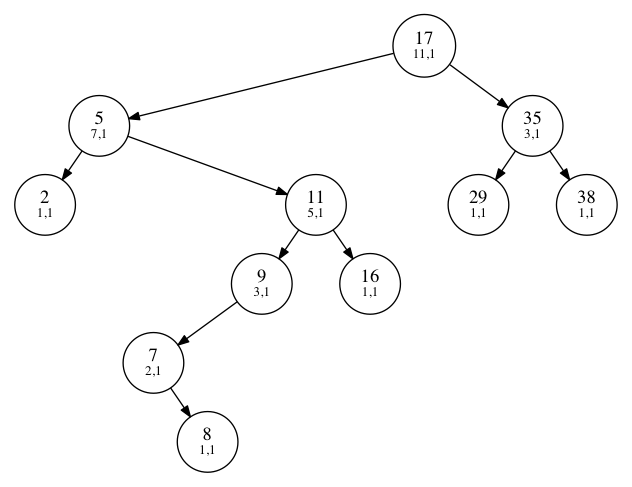

In [164]:
plotbtree(btree, 'oninsertsaug', augmented=True, redo=False)

In [129]:
btreedup = btree_fromlist(duplist, AugmentedBinarySearchTree)
print([e.data for e in btreedup], len(btreedup), len(duplist))

[2, 5, 5, 5, 7, 7, 8, 9, 9, 11, 16, 16, 17, 29, 35, 35, 38] 17 17


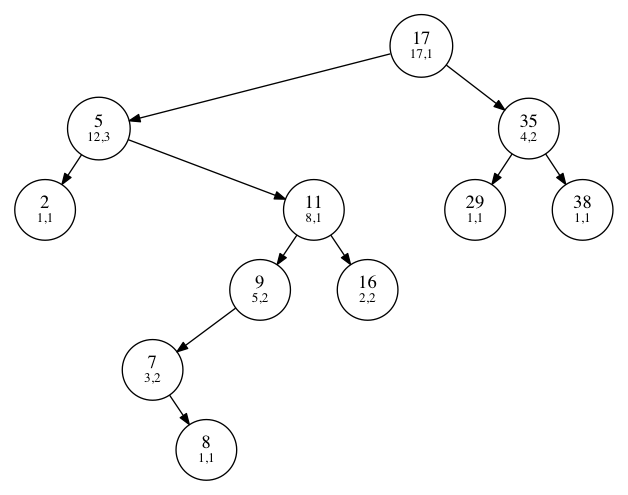

In [165]:
plotbtree(btreedup, 'oninsertsdupaug', augmented=True, redo=True)

In [130]:
for v in ourlist:
    print(v, btree.rankof(v))

17 [7]
5 [1]
35 [9]
2 [0]
11 [5]
29 [8]
38 [10]
9 [4]
16 [6]
7 [2]
8 [3]


In [131]:
for v in duplist:
    print(v, btreedup.rankof(v))

17 [12]
5 [1, 2, 3]
35 [14, 15]
2 [0]
11 [9]
29 [13]
38 [16]
9 [7, 8]
16 [10, 11]
7 [4, 5]
8 [5]
7 [4, 5]
35 [14, 15]
5 [1, 2, 3]
16 [10, 11]
9 [7, 8]
5 [1, 2, 3]


## Q2.

Implement a Key-Value Search true, which allows no duplicates, but rather, updates the value associated with the key. This will change how `insert` works. Inherit from the augmented tree:

`class KeyValueBinarySearchTree(AugmentedBinarySearchTree):`

- The constructor should look like this: `def __init__(self, key_value_tuple, parent=None):`. Pick the key and value out separately in the constructor, and initialize the super with just the key, setting an instance variable `self.value` to the value.
- insert wont duplicate any more, and `addLeftChild` and `addRightChild` will need to take the tuple in as they call the constructor for us.
- implement a `__getitem__`, `__setitem__`, and `__delitem__` so that you can use code like:

`btreekv['f']` for searching

`btreekv['f']=10` for inserting

In [182]:
class KeyValueBinarySearchTree(AugmentedBinarySearchTree):
    """
    str1 < str2 if str1 comes before self.key in alphabetical ordering
    For example: 'abc' < 'bac'
    """
    
    def __init__(self, key_value_tuple, parent=None):
        key, value = key_value_tuple
        super().__init__(key, parent)
        self.value = value
        
    def insert(self, key_value_tuple):
        key, value = key_value_tuple
        if key < self.data:
            if self.hasLeftChild():
                self.left.insert(key_value_tuple)
            else:
                self.addLeftChild(key_value_tuple)
                self._insert_hook()
        elif key > self.data:
            if self.hasRightChild():
                self.right.insert(key_value_tuple)
            else:
                self.addRightChild(key_value_tuple)
                self._insert_hook()
        else:  # duplicate value
            self.value = value
    
    def addLeftChild(self, key_value_tuple): 
        key, value = key_value_tuple
        n = self.__class__(key_value_tuple, self)
        self.left = n
        self.left.value = value
        return n
    
    def addRightChild(self, key_value_tuple): 
        key, value = key_value_tuple
        n = self.__class__(key_value_tuple, self)
        self.right = n
        self.right.value = value
        return n
    
    def __getitem__(self, key):
        node = self.search(key)
        if node:
            return node.value
        raise ValueError("no such key {} in tree".format(key))
        
    def __setitem__(self, key, value):
        node = self.search(key)
        if node:
            node.value = value
        else:
            self.insert((key, value))
        
    def __delitem__(self, key):
        self.delete(key)
        
#     def _insert_hook(self):
#         pass
            
#     def _remove_hook(self, up=False, by=1):
#         pass

In [183]:
btreekv = KeyValueBinarySearchTree(('f', 3))

In [184]:
kvdata=zip(list('jeihrifhkdfks'), range(13))

In [185]:
for k,v in kvdata:
    btreekv[k]=v

In [186]:
[(e.data, e.value) for e in list(btreekv)]

[('d', 9),
 ('e', 1),
 ('f', 10),
 ('h', 7),
 ('i', 5),
 ('j', 0),
 ('k', 11),
 ('r', 4),
 ('s', 12)]

In [187]:
btreekv['f']

10

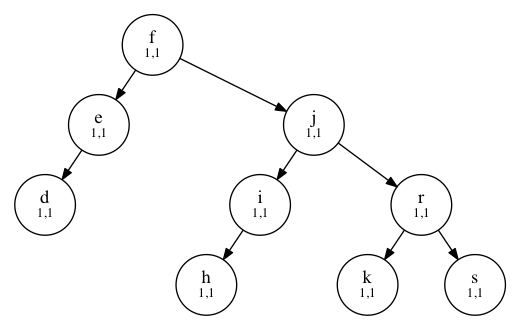

In [188]:
plotbtree(btreekv, 'oninsertsdupaugkv', augmented=True, redo=False)

## Q3.

Use your code to make a third implementation of the `SimpleSet` interface from Monday.

In [271]:
class SimpleSetKV:
    def __init__(self, data):
        self._storage = KeyValueBinarySearchTree(data[0])
        for i in range(1, len(data)):
            self._storage.insert(data[i])
        
    def __len__(self):
        return self._storage.size
        
    def __iter__(self):
        for i in self._storage:
            yield (i.data, i.value)
    
    def __contains__(self, item)->bool:
        return item in self._storage
        
    def add(self, item)->None:
        self._storage.insert(item)
        
    def rem(self, item)->None:
        self._storage.__delete__(item)
        
    def union(self, other):
        s = SimpleSetKV(list(self))
        for i in other:
            s.add(i)  # no repeats in a KeyValueBinarySearchTree, so we don't have to worry
        return s
        
    def intersection(self, other):
        tuple_list = []
        for (i, j) in zip(list(self), list(other)):
            if i == j:
                tuple_list.append(i)                
        return SimpleSetKV(tuple_list)

In [272]:
# tests
s = SimpleSetKV([('a', 1)])
s.add(('c',3))

In [274]:
for i in s:
    print (i)

('a', 1)
('c', 3)


In [275]:
q = SimpleSetKV([('a', 1), ('b', 2)])

In [276]:
for i in s.union(q):
    print (i)

('a', 1)
('b', 2)
('c', 3)


In [277]:
for i in s.intersection(q):
    print (i)

('a', 1)
